In [1]:
import seaborn as sns

In [4]:
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [5]:
from matplotlib import rcParams

# Set global font properties to Arial
rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": "Arial",
        "pdf.fonttype": 42,  # Embed fonts as Type 3 fonts for compatibility
        "ps.fonttype": 42,
        "text.usetex": False,
        "svg.fonttype": "none",
    }
)

rcParams.update(
    {
        "font.size": 24,  # Set a default font size
        "legend.fontsize": 16,
        "legend.handlelength": 2,
    }
)
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["axes.labelsize"] = 16

In [6]:
# % colors
# \definecolor{mylightred}{RGB}{255,200,200}
# \definecolor{mylightblue}{RGB}{172,188,63}
# \definecolor{mylightgreen}{RGB}{150,220,150}
c1 = [i / 255 for i in (255, 200, 200)]
c2 = [i / 255 for i in (150, 220, 150)]
c3 = [i / 255 for i in (172, 188, 63)]

In [7]:
d1 = "#BF1D2D"
d2 = "#262626"
d3 = "#293890"

In [8]:
e1 = "#2F2D54"
e2 = "#9193B4"
e3 = "#BD9AAD"
e4 = "#E8D2B3"

# F1B  Simulation Result 

In [9]:
import matplotlib.pyplot as plt
import numpy as np


def simulation_plot(cl1, cl2, figsize=(7, 8)):
    # sns.set_context("paper", font_scale=1)

    cnn_name = "CNN"
    dc_name = "DeepChopper"

    data = {cnn_name: [0.87, 0.91], dc_name: [0.9636, 0.9951]}

    # Create a figure and axis
    _, ax = plt.subplots(figsize=figsize)

    # Define the F1 scores to plot
    f_scores = [0.2, 0.4, 0.6, 0.8, 0.9]

    # Initialize lists for lines and labels
    lines, labels = [], []

    # Plot F1 score iso-lines
    for f_score in f_scores:
        x = np.linspace(0.01, 1, 500)
        y = f_score * x / (2 * x - f_score)

        # Ensure y values are within [0, 1] range
        valid = (y >= 0) & (y <= 1)
        x = x[valid]
        y = y[valid]
        (l,) = plt.plot(x, y, color="gray", alpha=0.2, linewidth=3)

        # Add F1 score annotations
        plt.annotate(
            f"f1={f_score:0.1f}", xy=(0.9, f_score * 0.9 / (2 * 0.9 - f_score) + 0.02)
        )

    cnn_handle = plt.scatter(
        *data[cnn_name], c=cl1, s=120, label=cnn_name, alpha=1, edgecolors="none"
    )
    deepchopper_handle = plt.scatter(
        *data[dc_name], c=cl2, s=120, label=dc_name, alpha=1, edgecolors="none"
    )

    # # Add the scatter plots to handles
    handles = [cnn_handle, deepchopper_handle, l]
    labels = [cnn_name, dc_name, "Iso-f1 Curves"]
    plt.legend(handles=handles, labels=labels, loc="upper left")

    sns.despine(offset=10, trim=True)
    # Label the plot
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

    plt.tight_layout()

    plt.savefig("simulation_pr.pdf", dpi=300)

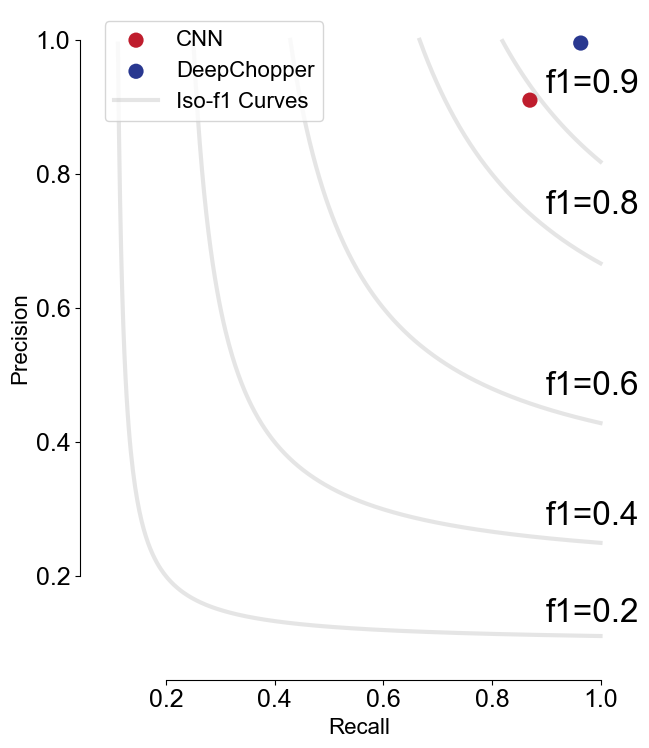

In [19]:
simulation_plot(d1, d3)

# F1C Bar PLot for Chemeric Read compare

In [10]:
type_names = ["Dorado with Trim", "Dorado w/o Trim", "DC"]

data = {
    type_names[0]: [107266, 6228],
    type_names[1]: [107304, 6228],
    type_names[2]: [9844, 4664],
}

data_with_validated = {
    "value": list(
        chain.from_iterable([[data[t][0] - data[t][1], data[t][1]] for t in type_names])
    ),
    "data type": list(chain.from_iterable([[i] * 2 for i in type_names])),
    "type": ["Unvalidated", "Validated"] * len(type_names),
}

In [11]:
data_df = pd.DataFrame(data_with_validated)

In [12]:
data_df

,value,data type,type
0,101038,Dorado with Trim,Unvalidated
1,6228,Dorado with Trim,Validated
2,101076,Dorado w/o Trim,Unvalidated
3,6228,Dorado w/o Trim,Validated
4,5180,DC,Unvalidated
5,4664,DC,Validated


In [75]:
data_df.groupby("data type")["value"].sum().reset_index()

,data type,value
0,DC,9844
1,Dorado w/o Trim,107304
2,Dorado with Trim,107266


In [76]:
# https://seaborn.pydata.org/tutorial/axis_grids.html#grid-tutorial

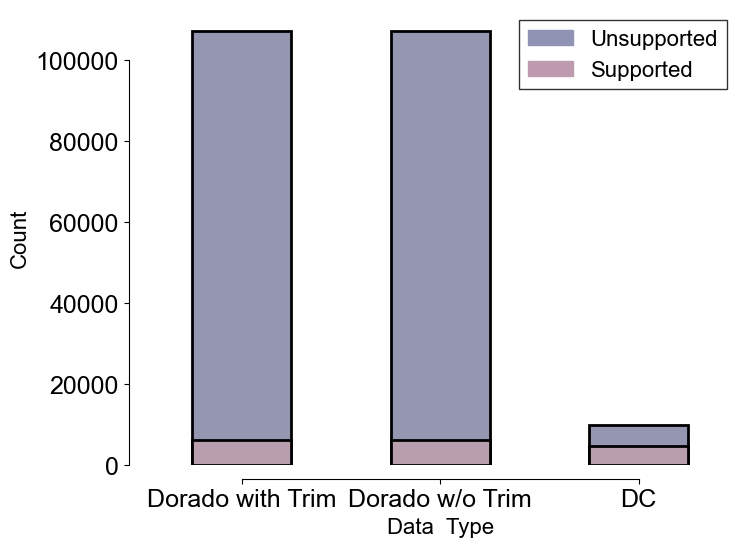

In [13]:
plt.figure(figsize=(8, 6))

bar1 = sns.barplot(
    data=data_df.groupby("data type")["value"].sum().reset_index(),
    x="data type",
    y="value",
    order=type_names,
    color=e2,
    edgecolor="k",
    linewidth=2,
    width=0.5,
)
bar2 = sns.barplot(
    data=data_df.query("type == 'Validated'"),
    x="data type",
    y="value",
    order=type_names,
    estimator=sum,
    color=e3,
    edgecolor="k",
    linewidth=2,
    width=0.5,
)

# add legend
top_bar = mpatches.Patch(color=e2, label="Unsupported")
bottom_bar = mpatches.Patch(color=e3, label="Supported")
plt.legend(handles=[top_bar, bottom_bar], edgecolor="k", fancybox=False)
sns.despine(offset=10, trim=True)

plt.ylabel("Count")
plt.xlabel("Data  Type")

plt.tight_layout()
plt.savefig("bar_plot_chemeric_read_cmp.pdf", dpi=300)

In [69]:
# plt.figure(figsize=(6, 6))
# total = data_df.groupby("data type")['value'].sum().reset_index()
# validated = data_df.query("type == 'Validated'").groupby("data type")['value'].sum().reset_index()
# validated['value'] = [i / j * 100 for i, j in zip(validated['value'], total['value'])]
# total['value'] = [i / j * 100 for i, j in zip(total['value'], total['value'])]

# bar1 = sns.barplot(x="data type", y="value", data=total, color=c1, edgecolor="k", linewidth=2)

# # bar chart 2 -> bottom bars (group of 'smoker=Yes')
# bar2 = sns.barplot(x="data type", y="value", data=validated, color=c2, edgecolor="k", linewidth=2)

# # add legend
# top_bar = mpatches.Patch(color=c1, label='Unvalidated')
# bottom_bar = mpatches.Patch(color=c2, label='Validated')
# plt.legend(handles=[top_bar, bottom_bar])
# sns.despine(offset=10, trim=True)

# plt.ylabel("Percent ($\%$)")
# plt.xlabel("Data  Type")

# plt.savefig(f'bar_plot_chemeric_read_cmp_same_height.pdf',
#             bbox_inches='tight',
#             dpi=300
#             )

In [113]:
data_with_validated

{'value': [101038, 6228, 101076, 6228, 5180, 4664],
 'data type': ['Dorado with Trim',
  'Dorado with Trim',
  'Dorado w/o Trim',
  'Dorado w/o Trim',
  'DC',
  'DC'],
 'type': ['Unvalidated',
  'Validated',
  'Unvalidated',
  'Validated',
  'Unvalidated',
  'Validated']}

In [92]:
# Figure 1D, E, F: BLAT, quality and PolyA motif for false positive chimeric artifacts.


# F1D BLAT for internal prediction FP (Dorado chemeric reads - DC chemeric reads)

In [14]:
import json

In [15]:
# load data
plot_data = json.load(open("data/internal_prediction_seq_blat_top1_indentities.json"))
plot_data_vcap_004 = json.load(
    open("data/fp_vcap_004_hyena_all_predicts_blat_identities.json")
)

In [16]:
len(plot_data)

98807

In [17]:
len(plot_data_vcap_004)

6185

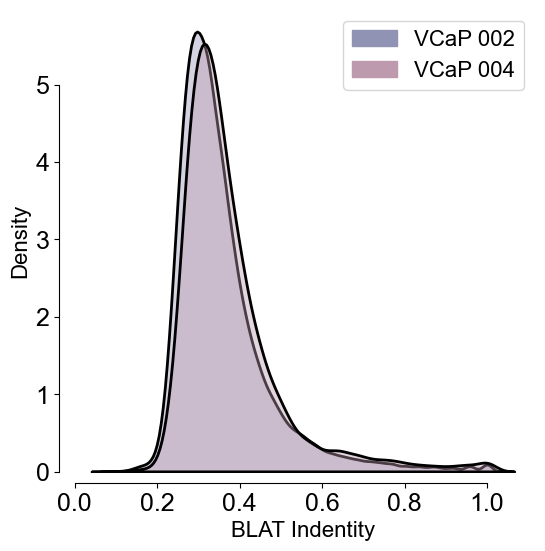

In [18]:
plt.figure(figsize=(6, 6))
sns.kdeplot(data=plot_data, fill=True, color=e2, edgecolor="k", linewidth=2, alpha=0.4)
sns.kdeplot(
    data=plot_data_vcap_004, fill=True, color=e3, edgecolor="k", linewidth=2, alpha=0.4
)

left_bar = mpatches.Patch(color=e2, label="VCaP 002")
right_bar = mpatches.Patch(color=e3, label="VCaP 004")
plt.legend(handles=[left_bar, right_bar], loc="upper right")

sns.despine(offset=8, trim=True)
plt.xlabel("BLAT Indentity")
# plt.ylabel("Density")
plt.savefig(
    "blat_for_fp_internal_prediction_cmp_with_dorado.pdf", bbox_inches="tight", dpi=300
)

# F1E Base Quals for internal prediction FP (Dorado chemeric reads - DC chemeric reads)

In [102]:
import json

In [103]:
def plot_qual(file_path):
    from needletail import parse_fastx_file

    quals = []
    for record in parse_fastx_file(file_path):
        current_quals = [ord(i) - 33 for i in list(record.qual)]
        quals.append(sum(current_quals) / len(current_quals))
    return quals

In [104]:
# load data
plot_data = json.load(open("data/internal_prediction_seq_base_quals.json"))

In [105]:
plot_data = [i - 33 for i in plot_data]

In [106]:
# load data
plot_qual_left_seq_data = plot_qual("./data/fp_dorado_heyna_vcap002.fq.gz")

In [107]:
len(plot_qual_left_seq_data)

88164

In [108]:
len(plot_data)

146580

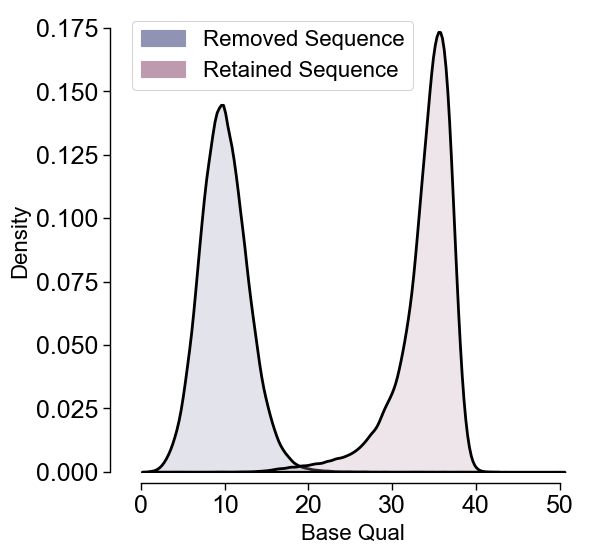

In [110]:
plt.figure(figsize=(6, 6))
sns.kdeplot(data=plot_data, fill=True, color=e2, edgecolor="k", linewidth=2)
sns.kdeplot(
    data=plot_qual_left_seq_data, fill=True, color=e3, edgecolor="k", linewidth=2
)

left_bar = mpatches.Patch(color=e2, label="Removed Sequence")
right_bar = mpatches.Patch(color=e3, label="Retained Sequence")
plt.legend(handles=[left_bar, right_bar], loc="upper left")

sns.despine(offset=8, trim=True)
plt.xlabel("Base Qual")
plt.ylabel("Density")
plt.savefig(
    "base_quals_for_fp_internal_prediction_cmp_with_dorado.pdf",
    bbox_inches="tight",
    dpi=300,
)

# Supplemental Figures